In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import json
import time
import pytensor 
import pymc as pm
import arviz as az
import jax
import jax.numpy as jnp
import pyhf
import scipy.stats as sps
pyhf.set_backend('jax')

from jax import grad, jit, vmap, value_and_grad, random
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import external

# Prior and Posterior Predictive Checks

## DisplacedLeptons

In [11]:
### Initializing the model for inference
    ## Output is of the form [pyhf model, observations, nBins]
# my_model = external.InferenceModel.build_model('ttbar_ljets_xsec_inclusive_pruned.json')
my_model = external.InferenceModel.build_model('SRee_SRmm_Srem.json')

In [12]:
### Sampling
post_data, post_pred = external.InferenceModel.posterior_sampling(my_model, 500)
prior_data = external.InferenceModel.prior_predictive(my_model, 500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_Sig]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [mu_Sig]
>Metropolis: [Normals]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


Sampling: [Normals, main, mu_Sig]


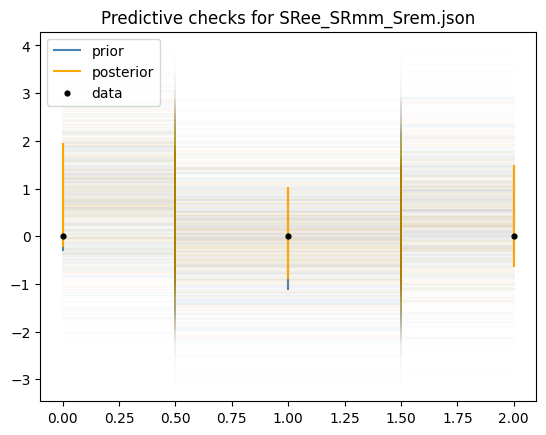

In [13]:
external.InferenceModel.plot_ppc(my_model, post_pred, prior_data)

In [6]:
pyhf.parameters.constrained_by_normal

pyhf.parameters.paramsets.constrained_by_normal

## ttbar

In [14]:
### Initializing the model for inference
    ## Output is of the form [pyhf model, observations, nBins]
my_model = external.InferenceModel.build_model('ttbar_ljets_xsec_inclusive_pruned.json')

In [15]:
### Sampling
post_data, post_pred = external.InferenceModel.posterior_sampling(my_model, 500)
prior_data = external.InferenceModel.prior_predictive(my_model, 500)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ttbarXsec]
>Metropolis: [Normals]
CompoundStep
>Metropolis: [ttbarXsec]
>Metropolis: [Normals]


Sampling: [Normals, main, ttbarXsec]


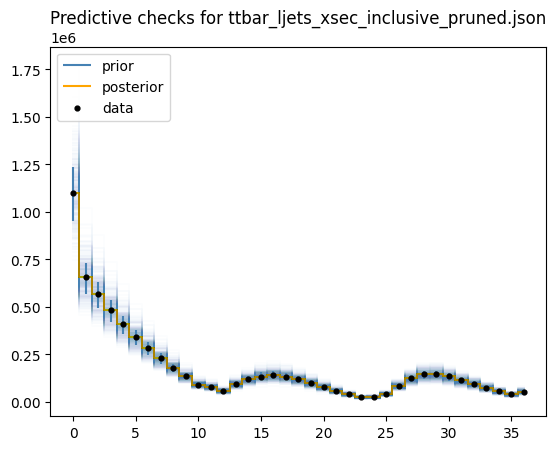

In [16]:
external.InferenceModel.plot_ppc(my_model, post_pred, prior_data)
